In [4]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import random
from functools import cmp_to_key

In [5]:
def generate_noise(n:int) -> torch.tensor:
    tmp = torch.randn(n, 3, 64, 64)
    tmp -= torch.min(tmp)
    return tmp / (torch.max(tmp) - torch.min(tmp))

def save_image(image:torch.tensor, path:str) -> None:
    transform = torchvision.transforms.ToPILImage()
    image.to("cpu")
    pil_image = transform(image.byte())
    pil_image.save(path, quality=100)

In [6]:
def load_dataset() -> tuple[torch.tensor, torch.tensor]:
    dataset = []

    path = os.path.join(os.getcwd(), "Dataset3")

    for relative_image_path in os.listdir(path):
        absolute_image_path = os.path.join(path, relative_image_path)
        if os.path.isfile(absolute_image_path):
            image = torchvision.io.read_image(absolute_image_path)[:3,:,:]
            image = image / 255.0
            dataset.append(image)

    return dataset

dataset = load_dataset()

Images : 390


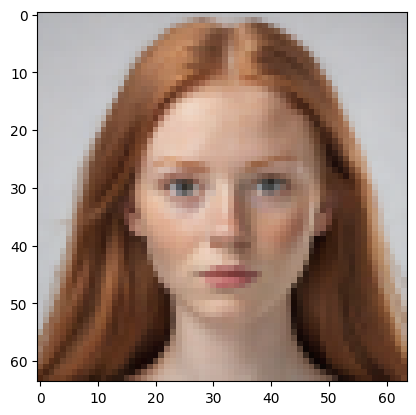

In [7]:
def plot_dataset_sample(nb_sample:int = 1) -> None:
    for _ in range(0, nb_sample):
        randIndex = random.randint(0, len(dataset))
        print("Images : " + str(randIndex))
        plt.imshow(dataset[randIndex].permute(1, 2, 0))
        plt.show()

nb_sample_to_plot = 1
plot_dataset_sample(nb_sample_to_plot)

In [8]:
def generate_noisy_image(image:torch.tensor, noise_level_input:float, noise_level_output:float) -> tuple[torch.tensor, torch.tensor]:
    noise_map = generate_noise(1)[0]
    noisy_image = image * (1.0 - noise_level_input) + (noise_map * noise_level_input)
    denoised_image = image * (1.0 - noise_level_output) + (noise_map * noise_level_output)

    return (noisy_image, denoised_image)

def generate_noisy_dataset(noise_level_input:float, noise_level_output:float, nb_variant:int) -> tuple[list, list]:
    X = []
    Y = []

    for _ in range(0, nb_variant):
        for image in dataset:
            noisy_image, denoised_image = generate_noisy_image(image, noise_level_input, noise_level_output)
            X.append(noisy_image)
            Y.append(denoised_image)

    return (X, Y)

Image 1110 : 


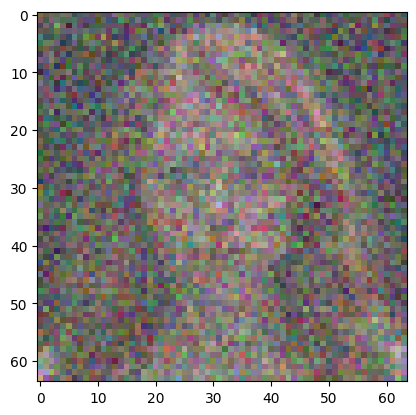

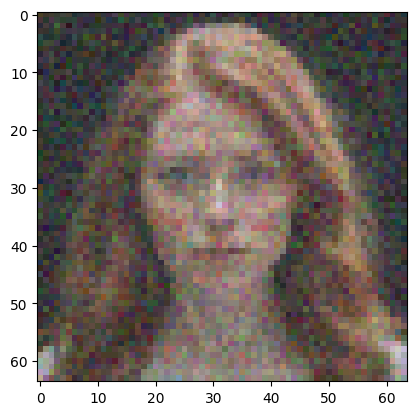

In [9]:
def show_noisy_dataset_sample(noise_level_input:float, noise_level_output:float, nb_samples:int):
    (X, Y) = generate_noisy_dataset(noise_level_input, noise_level_output, 1)

    for _ in range(0, nb_samples):
        rand_index = random.randint(0, len(X))
        print(f"Image {rand_index} : ")
        plt.imshow((X[rand_index] * 255.5).to(torch.uint8).permute(1, 2, 0))
        plt.show()
        plt.imshow((Y[rand_index] * 255.5).to(torch.uint8).permute(1, 2, 0))
        plt.show()

nb_samples = 1
show_noisy_dataset_sample(0.7, 0.4, nb_samples)

In [1]:
class Denoiser(nn.Module):
    def __init__(self) -> None:
        super(Denoiser, self).__init__()

        #Encoder
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        #Decoder
        self.conv5 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(64, 3, kernel_size=3, padding=1)

        self.blur = torchvision.transforms.GaussianBlur(3, sigma=(0.1, 0.2))


    def forward(self, x:list[torch.tensor]) -> list[torch.tensor]:

        x0 = x

        # encoder
        x0 = self.conv1(x0)
        x0 = F.relu(x0)
        x0 = self.conv2(x0)
        x0 = F.relu(x0)
        x0 = self.conv3(x0)
        x0 = F.relu(x0)
        x0 = self.conv4(x0)
        x0 = F.relu(x0)

        x1 = x0

        #decoder
        x1 = self.conv5(x1)
        x1 = F.relu(x1)
        print(x1.size())
        x1 = self.conv6(x1)
        x1 = F.relu(x1)
        x1 = self.conv7(x1)
        x1 = F.relu(x1)
        x1 = self.conv8(x1)
        x1 = F.sigmoid(x1)

        x1 = self.blur(x1)

        return x1

NameError: name 'nn' is not defined

In [12]:
def load() -> list[Denoiser]:
    models = []

    path = os.path.join(os.getcwd(), "Models", "Diffusers")
    nb_models = len(os.listdir(path))

    for i in range(0, nb_models):
        model = Denoiser()
        model.load_state_dict(torch.load(os.path.join(path, f"diffuser{i}.model")))
        models.append(model)

    return models

models = load()

In [13]:
lr = 0.0005
batch_size = 70
epochs = 5
print_epoch_interval = 1
epoch_to_show_sample = [3, 5]
saving_model = True
continue_training = True
noise_levels = [0.0, 0.14, 0.27, 0.39, 0.5, 0.6, 0.69, 0.77, 0.84, 0.9, 0.94, 0.97, 1.0]
nb_noise_variant = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device : " + device)

Device : cuda


In [ ]:
def train(model:Denoiser, criterion, noise_level_input:float, noise_level_output:float, model_name:str) -> Denoiser:

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    print("Start training denoiser : " + model_name)
    for epoch in range(0, epochs):
        print_sample = (epoch + 1) in epoch_to_show_sample

        X_train, y_train = generate_noisy_dataset(noise_level_input, noise_level_output, nb_noise_variant)
        X_train = torch.stack(X_train).to(device)
        y_train = torch.stack(y_train).to(device)

        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

        for inputs_batch, expected_outputs_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(inputs_batch)
            loss = criterion(outputs_batch, expected_outputs_batch)
            loss.backward()
            optimizer.step()

            if print_sample:
                with torch.no_grad():
                    print_sample = False
                    input = (255.0 * inputs_batch[0]).to(torch.uint8).to('cpu')
                    output = (255.0 * outputs_batch[0]).to(torch.uint8).to('cpu')
                    output_expected = (255.0 * expected_outputs_batch[0]).to(torch.uint8).to('cpu')
                    plt.imshow(input.permute(1, 2, 0))
                    plt.show()
                    plt.imshow(output.permute(1, 2, 0))
                    plt.show()
                    plt.imshow(output_expected.permute(1, 2, 0))
                    plt.show()

        if(epoch == 0 or  (epoch+1) % print_epoch_interval == 0 or epoch + 1 == epochs):
            print(f"Epoch {epoch+1}, Loss: {loss.item()}")

    if saving_model:
        path = os.path.join(os.getcwd(), "Models", "Diffusers", model_name + ".model")
        if os.path.isfile(path):
            os.remove(path)

        torch.save(model.state_dict(), path)
        print("Model : " + model_name + " Saved!")

    return model


if not continue_training:
    models = []
    
criterion = nn.MSELoss()
noise_levels = sorted(noise_levels, reverse=True)

for i in range(0, len(noise_levels) - 1):
    model = Denoiser()
    train(model, criterion, noise_levels[i], noise_levels[i + 1], "diffuser" + str(i))
    models.append(model)

In [ ]:
def compute_mean_loss(criterion) -> list[float]:

    loss = [0.0 for _ in range(0, len(models))]

    for i in range(0, len(models)):

        X_test, y_test = generate_noisy_dataset(noise_levels[i], noise_levels[i + 1], 1)
        X_test = torch.stack(X_test).to(device)
        y_test = torch.stack(y_test).to(device)
        models[i].to(device)

        for k in range(0, len(X_test)):
            inputs =  torch.stack([X_test[k]]).float().to(device)
            outputs_test = models[i](inputs)
            loss[i] += criterion(y_test[k].unsqueeze(0), outputs_test)

        #loss[i] /= float(len(X_test))

        return loss

mean_loss = compute_mean_loss(nn.MSELoss())
print(mean_loss)

In [ ]:
def test_models(start_model_index:int) -> None:

    def show_current_step(step:int, current_img:torch.tensor) -> None:
        print("step : " + str(step))
        tmp = (255.0 * current_img).to(torch.uint8).to('cpu').permute(1, 2, 0)
        plt.imshow(tmp)
        plt.show()

    rand_index = random.randint(0, len(dataset))
    clean_img = dataset[rand_index]
    current_img, _ = generate_noisy_image(clean_img, noise_levels[start_model_index], noise_levels[start_model_index + 1])
    step = start_model_index
    current_img.to('cpu')

    for i in range(start_model_index, len(models)):
        models[i].to('cpu')

        show_current_step(step, current_img)
        
        current_img = models[i](current_img)
        step += 1

    show_current_step(step, current_img)
    print("clean image:")
    show_current_step(step, clean_img)


noise_levels = sorted(noise_levels, reverse=True)
test_models(6)

In [ ]:
def generate_faces(nb_images:int, show_intermediate_step:bool = True, save_images:bool = True) -> None:    

    def show_current_step(step:int, current_img:torch.tensor) -> None:
        print("step : " + str(step))
        tmp = (255.0 * current_img).to(torch.uint8).to('cpu').permute(1, 2, 0)
        plt.imshow(tmp)
        plt.show()

    for k in range(0, nb_images):

        print(f"Processing image {k + 1}")
        
        current_img = generate_noise(1)[0].to(device)
        step = 0

        for i in range(0, len(models)):
            models[i].to(device)

            if show_intermediate_step:
                show_current_step(step, current_img)
            
            current_img = models[i](current_img)
            step += 1

        show_current_step(step, current_img)

        if save_image:
            images_path = os.path.join(os.getcwd(), "GeneratedImages")
            img_name = f"image{len(os.listdir(images_path))}.jpg"
            current_img = (255.0 * current_img).to(torch.uint8).to('cpu')
            save_image(current_img, os.path.join(images_path, img_name))

generate_faces(2, True, False)